In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [36]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [39]:
[column for column in Measurement.__table__.columns]

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.
# Query for the latest date using func.max()
latest_date = session.query(func.max(Measurement.date)).scalar()

# Print the latest date
print(latest_date)

2017-08-23


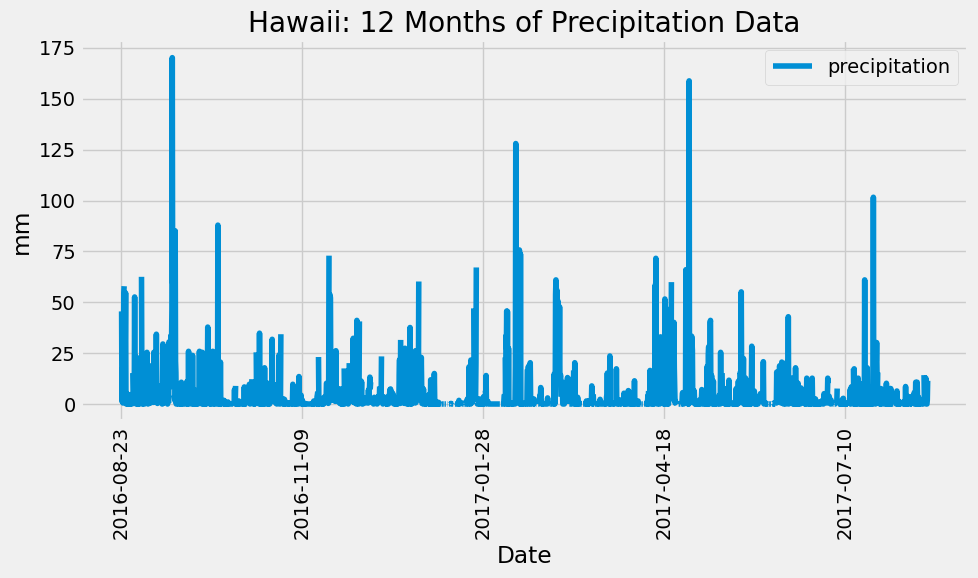

In [78]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(func.max(func.strftime('%Y-%m-%d', Measurement.date))).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(latest_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= one_year_ago.strftime('%Y-%m-%d')).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='precipitation', figsize=(10, 6), legend=False)
plt.xlabel("Date")
plt.ylabel("mm")
plt.title("Hawaii: 12 Months of Precipitation Data")
plt.xticks(rotation=90)
plt.legend(["precipitation"])
plt.tight_layout()
plt.show()

# Close the session
session.close()

In [80]:
# Calculate the statistics
statistics_series = df['precipitation'].describe()

# Reset the index
statistics_df = statistics_series.reset_index()

# Rename the index name to an empty string
statistics_df.rename(columns={'index': ''}, inplace=True)

# Set the 'Statistic' column as the index
statistics_df.set_index('', inplace=True)

# Print the DataFrame
statistics_df

,precipitation
,
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_count = [(session.query(func.count(func.distinct(Station.station))).scalar(),)]

# Print the station count
print(station_count)

[(9,)]


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Unpack the most active station ID
most_active_station_id = most_active_station[0]

results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()


# Unpack the results
lowest_temp, highest_temp, average_temp = results[0]

results

[(12.2, 29.4, 22.03582251082252)]

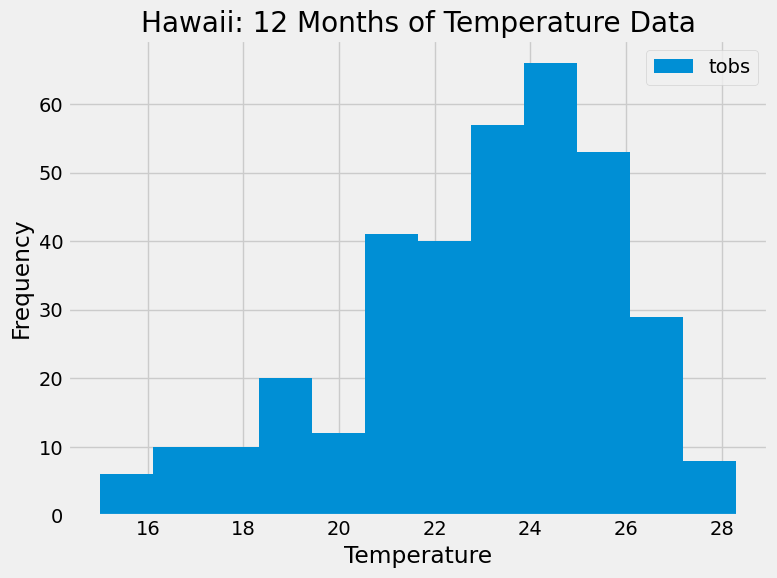

In [83]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Unpack the most active station ID
most_active_station_id = most_active_station[0]

# Calculate the date one year from the last date in the dataset
latest_date = session.query(func.max(func.strftime('%Y-%m-%d', Measurement.date))).scalar()
one_year_ago = (pd.to_datetime(latest_date) - pd.DateOffset(days=365)).date()

# Perform a query to retrieve the temperature observations for the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= one_year_ago.strftime('%Y-%m-%d')).all()

# Unpack the temperature observations
temperatures = [temp[0] for temp in temperature_data]

# Plot the temperature data as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Hawaii: 12 Months of Temperature Data")
plt.legend(["tobs"], loc="upper right")
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()